# Fraud Detection in Amazon SageMaker using Clickhouse as Feature Store

## 1. Connect to Clickhouse

Install the [Clickhouse Connect](https://clickhouse.com/docs/en/integrations/python) Python driver. 

In [1]:
!pip install clickhouse-connect

Connect to Clickhouse.

In [2]:
import clickhouse_connect

client = clickhouse_connect.get_client(
    host='<host>',
    port=8443,
    username='default',
    password='<password>'
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Set up the SageMaker environment.

In [3]:
import sagemaker
from sagemaker.hyperparameters import retrieve_default
from sagemaker.explainer.explainer_config import ExplainerConfig
from sagemaker.explainer.clarify_explainer_config import ClarifyExplainerConfig, ClarifyInferenceConfig, ClarifyShapConfig, ClarifyShapBaselineConfig

serializer = sagemaker.serializers.CSVSerializer()
deserializer = sagemaker.deserializers.JSONDeserializer()
session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
instance_type = 'ml.m5.2xlarge'
model_id = 'catboost-classification-model'
model_version = '*'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Import all the other dependencies.

In [4]:
import io
import json
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

## 2. Explore the data in Clickhouse

We use  a subset of the [Credit Card Transactions Fraud Detection Dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection/data), which we have already loaded in a table in Clickhouse. The dataset contains 120,000 artificially generated credit card transactions between the 1st of January 2019 and the 31st of December 2020. Approximately 4% of the transactions are fraudulent.

In [5]:
data = client.query_df('select * from fraud_data order by trans_date_trans_time asc')

In [6]:
data.shape

(120000, 23)

In [7]:
data.head()

,split,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,train,2019-01-01 00:52:57,3501509250702469,fraud_Hackett-Lueilwitz,grocery_pos,59.56,Frank,Anderson,M,0611 Stafford Valley Suite 504,...,26.1184,-81.7361,276002,"Programme researcher, broadcasting/film/video",1979-01-02,e922037de4ac8a6bec29be758e4ce195,1325379177,25.801181,-82.351291,0
1,train,2019-01-01 00:57:17,378006354724784,fraud_Ankunding LLC,shopping_net,94.53,Christopher,Matthews,M,433 John Heights Apt. 849,...,38.5095,-78.2638,395,Senior tax professional/tax inspector,1982-01-07,d513918bedeff433054b9384483bd79c,1325379437,37.846760,-79.262334,0
2,train,2019-01-01 00:58:02,4481131401752,"fraud_Greenholt, Jacobi and Gleason",gas_transport,75.77,Frank,Foster,M,37910 Ward Lights,...,42.2848,-71.7205,35299,English as a second language teacher,1975-04-30,1240cd77c20744f96aa5e6a5cf9b1fcf,1325379482,42.889256,-71.888107,0
3,train,2019-01-01 01:02:53,571365235126,fraud_VonRueden Group,grocery_net,89.35,Barbara,Taylor,F,0069 Robin Brooks Apt. 695,...,44.5995,-86.2141,372,"Exhibitions officer, museum/gallery",1995-07-12,bce01a6ae8b8c6227cd4f1de751c017c,1325379773,44.630758,-87.123894,0
4,train,2019-01-01 01:09:41,4683520018489354,fraud_Ledner-Pfannerstill,gas_transport,90.54,Charles,Carrillo,M,17547 Stephen Turnpike Apt. 846,...,33.9143,-118.3493,93193,"Editor, magazine features",1995-04-19,295b782f9fa48f76f508179ec6412f9d,1325380181,32.990285,-117.836803,0


In [8]:
data['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.958
1    0.042
Name: proportion, dtype: float64

## 3. Create a feature store in Clickhouse

We will use the [CatBoost SageMaker algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/catboost.html) for classifying the transactions into fraudulent (positive class) and not fraudulent (negative class). We will use as features the merchant and category of the transaction, the customer's age and city, the transaction amount, the hour and day of the week of the transaction, the distance between the customer's address and the merchant's address, the average amount of the customer's transactions over the last 24 hours and the number of transactions made by the customer over the last 24 hours. 

We use a [Clickhouse normal view](https://clickhouse.com/docs/en/sql-reference/statements/create/view#normal-view) for feature engineering. The view stores a query which extracts the raw data from the main table and performs the required transformations. This view will be our *feature store* used for both training and inference. 

We use various Clickhouse functions for feature engineering, such as the `toHour` and `toDayOfWeek` functions which extract the hour and weekday from a timestamp, the `geoDistance` function which calculates the distance in meters between two pairs of latitude-longitude coordinates (in this case the customer's address and the merchant's address) as well as [Clickhouse window functions](https://clickhouse.com/docs/en/sql-reference/window-functions) which allow us to calculate the number of transactions and the average transaction amount of each customer over rolling windows of 24 hours.

In [9]:
client.command(
    '''
    drop view if exists fraud_feature_store sync
    '''
)

client.command(
    '''
    create view
        fraud_feature_store
    as select
        trans_date_trans_time,
        cc_num,
        merchant,
        category,
        toInt32((now() - dob) / (60 * 60 * 24 * 365)) as customer_age,
        city as customer_city,
        amt as transaction_amount,
        toHour(trans_date_trans_time) as transaction_hour,
        toDayOfWeek(trans_date_trans_time) as transaction_weekday,
        geoDistance(long, lat, merch_long, merch_lat) / 1000 as merchant_distance,
        avg(amt) over (partition by cc_num order by toHour(trans_date_trans_time) Range between 24 preceding and current row) as average_transaction_amount_1_day,
        count(*) over (partition by cc_num order by toHour(trans_date_trans_time) Range between 24 preceding and current row) as transaction_count_1_day
    from
        fraud_data
    '''
)

## 4. Train the model

We query the training data from Clickhouse and save it in a CSV file in S3, making sure to include the target variable in the first column as required by the algorithm.

In [10]:
train_data = client.query_df(
    '''
    select
        a.is_fraud as is_fraud,
        b.merchant as merchant,
        b.category as category,
        b.customer_age as customer_age,
        b.customer_city as customer_city,
        b.transaction_amount as transaction_amount,
        b.transaction_hour as transaction_hour,
        b.transaction_weekday as transaction_weekday,
        b.merchant_distance as merchant_distance,
        b.average_transaction_amount_1_day as average_transaction_amount_1_day,
        b.transaction_count_1_day as transaction_count_1_day
    from
        fraud_data as a
    left join
        fraud_feature_store as b
    on
        a.trans_date_trans_time == b.trans_date_trans_time
    and
        a.cc_num == b.cc_num
    where
        a.split == 'train'
    order by
        a.trans_date_trans_time asc
    '''
)

In [11]:
train_data.head()

,is_fraud,merchant,category,customer_age,customer_city,transaction_amount,transaction_hour,transaction_weekday,merchant_distance,average_transaction_amount_1_day,transaction_count_1_day
0,0,fraud_Hackett-Lueilwitz,grocery_pos,45,Naples,59.56,0,2,70.930820,83.906000,10
1,0,fraud_Ankunding LLC,shopping_net,41,Etlan,94.53,0,2,114.308852,109.044000,5
2,0,"fraud_Greenholt, Jacobi and Gleason",gas_transport,48,Shrewsbury,75.77,0,2,68.539891,186.232500,8
3,0,fraud_VonRueden Group,grocery_net,28,Elberta,89.35,1,2,72.298273,100.386800,25
4,0,fraud_Ledner-Pfannerstill,gas_transport,28,Hawthorne,90.54,1,2,113.017727,55.277273,11


In [12]:
train_data_file = session.upload_string_as_file_body(
    body=train_data.to_csv(index=False, header=False),
    bucket=bucket,
    key='train/data.csv'
)

train_data_file

's3://sagemaker-eu-west-2-865186622207/train/data.csv'

We also create a JSON file with the column indices of the categorical features and save it in S3 together with the training data. 

In [13]:
cat_index_file = session.upload_string_as_file_body(
    body=json.dumps(dict(cat_index_list=[1, 2, 4, 6, 7])),
    bucket=bucket,
    key='train/categorical_index.json'
)

cat_index_file

's3://sagemaker-eu-west-2-865186622207/train/categorical_index.json'

Now that the training data is available in S3, we can proceed to training the model. Given that the dataset is imbalanced (as the proportion of fraudulent transactions is very small), we set the `scale_pos_weight` hyperparameter (which by default is set equal to one) equal to the ratio between the number of training samples in the negative class and the number of training samples in the positive class.

In [14]:
# get the default hyperparameters
hyperparameters = retrieve_default(
    model_id=model_id,
    model_version=model_version
)

# update the 'scale_pos_weight' hyperparameter
hyperparameters['scale_pos_weight'] = (train_data['is_fraud'] == 0).sum() / (train_data['is_fraud'] == 1).sum()

hyperparameters

Using model 'catboost-classification-model' with wildcard version identifier '*'. You can pin to version '2.1.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


{'iterations': '500',
 'early_stopping_rounds': '5',
 'eval_metric': 'Auto',
 'learning_rate': '0.03',
 'depth': '6',
 'l2_leaf_reg': '3',
 'random_strength': '1.0',
 'max_leaves': '31',
 'rsm': '1',
 'sampling_frequency': 'PerTreeLevel',
 'min_data_in_leaf': '1',
 'bagging_temperature': '1',
 'boosting_type': 'Auto',
 'scale_pos_weight': 24.673940949935815,
 'max_bin': 'Auto',
 'grow_policy': 'SymmetricTree',
 'random_seed': '0',
 'thread_count': '-1',
 'verbose': '1'}

After that we proceed with training the model.

In [15]:
# retrieve the URI of the training image
training_image_uri = sagemaker.image_uris.retrieve(
    region=None,
    framework=None,
    model_id=model_id,
    model_version=model_version,
    image_scope='training',
    instance_type=instance_type
)

# retrieve the URI of the training script
training_source_uri = sagemaker.script_uris.retrieve(
    model_id=model_id,
    model_version=model_version,
    script_scope='training',
)

# retrieve the URI of the pre-trained model; this is not used
# in this case, but the estimator requires it as an input
training_model_uri = sagemaker.model_uris.retrieve(
    model_id=model_id,
    model_version=model_version,
    model_scope='training',
)

# create the estimator
estimator = sagemaker.estimator.Estimator(
    role=role,
    image_uri=training_image_uri,
    source_dir=training_source_uri,
    model_uri=training_model_uri,
    instance_count=1,
    instance_type=instance_type,
    max_run=3600,
    output_path=f's3://{bucket}/output',
    entry_point='transfer_learning.py',
    hyperparameters=hyperparameters,
)

# run the training job
estimator.fit({'training': f's3://{bucket}/train'})

INFO:sagemaker:Creating training-job with name: sagemaker-jumpstart-2023-12-23-13-31-15-877


2023-12-23 13:31:16 Starting - Starting the training job...
2023-12-23 13:31:32 Starting - Preparing the instances for training......
2023-12-23 13:32:28 Downloading - Downloading input data...
2023-12-23 13:33:08 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-23 13:33:24,715 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-23 13:33:24,717 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-23 13:33:24,726 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-23 13:33:24,727 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-12-23 13:33:26,489 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Pr

## 5. Deploy the model

After the model has been trained, we deploy it to a real-time inference endpoint. We enable online explainability through [SageMaker Clarify](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-model-explainability.html) in order to examine the impact of the different features on the model output. We set the baseline with respect to which the [Shapley Values](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-shapley-values.html) are calculated equal to the mode in the case of categorical features, and to the mean in the case of numerical features. We calculate the mean and the mode directly in the Clickhouse feature store using the `avg` and `topK` functions.

In [16]:
baseline = client.query_df(
    '''
    select
        topK(1)(merchant) as merchant,
        topK(1)(category) as category,
        avg(customer_age) as customer_age,
        topK(1)(customer_city) as customer_city,
        avg(transaction_amount) as transaction_amount,
        topK(1)(transaction_hour) as transaction_hour,
        topK(1)(transaction_weekday) as transaction_weekday,
        avg(merchant_distance) as merchant_distance,
        avg(average_transaction_amount_1_day) as average_transaction_amount_1_day,
        avg(transaction_count_1_day) as transaction_count_1_day
    from
        fraud_feature_store
    '''
)

baseline.to_dict(orient='records')

[{'merchant': ['fraud_Gaylord-Powlowski'],
  'category': ['grocery_pos'],
  'customer_age': 38.664225,
  'customer_city': ['Prosperity'],
  'transaction_amount': 88.52343166666665,
  'transaction_hour': [23],
  'transaction_weekday': [1],
  'merchant_distance': 76.18505266899834,
  'average_transaction_amount_1_day': 96.92008317849316,
  'transaction_count_1_day': 158.35305833333334}]

We also extract the names of the features, as this will help with mapping the Shapley Values to the correct variables.

In [17]:
feature_headers = baseline.columns.tolist()

feature_headers

['merchant',
 'category',
 'customer_age',
 'customer_city',
 'transaction_amount',
 'transaction_hour',
 'transaction_weekday',
 'merchant_distance',
 'average_transaction_amount_1_day',
 'transaction_count_1_day']

We then proceed to creating the endpoint.

In [18]:
# retrieve the URI of the inference image
inference_image_uri = sagemaker.image_uris.retrieve(
    region=None,
    framework=None,
    image_scope='inference',
    model_id=model_id,
    model_version=model_version,
    instance_type=instance_type,
)

# retrieve the URI of the inference script
inference_source_uri = sagemaker.script_uris.retrieve(
    model_id=model_id,
    model_version=model_version,
    script_scope='inference',
)

# deploy the model
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    entry_point='inference.py',
    image_uri=inference_image_uri,
    source_dir=inference_source_uri,
    explainer_config=ExplainerConfig(
        clarify_explainer_config=ClarifyExplainerConfig(
            inference_config=ClarifyInferenceConfig(
                feature_headers=feature_headers,
                probability_attribute='probabilities'
            ),
            shap_config=ClarifyShapConfig(
                shap_baseline_config=ClarifyShapBaselineConfig(
                    mime_type='text/csv',
                    shap_baseline=serializer.serialize(baseline)
                ),
                seed=42,
            )
        )
    ),
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-eu-west-2-865186622207/output/sagemaker-jumpstart-2023-12-23-13-31-15-877/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-eu-west-2/source-directory-tarballs/catboost/inference/classification/v1.1.2/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-eu-west-2-865186622207/sagemaker-jumpstart-2023-12-23-13-34-28-504/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-12-23-13-34-28-504
INFO:sagemaker:Creating endpoint-config with name sagemaker-jumpstart-2023-12-23-13-34-28-504
INFO:sagemaker:Creating endpoint with name sagemaker-jumpstart-2023-12-23-13-34-28-504


----!

## 6 Evaluate the model

To quickly evaluate the model performance, we invoke the endpoint with online explainability disabled. We stream the test data from Clickhouse in data frame format, invoke the endpoint with each block of test data, and save the results back to Clickhouse.

In [19]:
# create a Clickhouse table for storing the results
client.command(
    '''
    drop table if exists fraud_model_evaluation sync
    '''
)

client.command(
    '''
    create or replace table fraud_model_evaluation (
        trans_date_trans_time DateTime,
        cc_num Int64,
        actual_label Float64,
        predicted_label Float64,
        predicted_probability Float64,
    )
    engine
        MergeTree
    order by
        trans_date_trans_time
    '''
)

# stream blocks of test data from Clickhouse
with client.query_df_stream(
    '''
    select
        a.trans_date_trans_time as trans_date_trans_time,
        a.cc_num as cc_num,
        a.is_fraud as is_fraud,
        b.merchant as merchant,
        b.category as category,
        b.customer_age as customer_age,
        b.customer_city as customer_city,
        b.transaction_amount as transaction_amount,
        b.transaction_hour as transaction_hour,
        b.transaction_weekday as transaction_weekday,
        b.merchant_distance as merchant_distance,
        b.average_transaction_amount_1_day as average_transaction_amount_1_day,
        b.transaction_count_1_day as transaction_count_1_day
    from
        fraud_data as a
    left join
        fraud_feature_store as b
    on
        a.trans_date_trans_time == b.trans_date_trans_time
    and
        a.cc_num == b.cc_num
    where
        a.split == 'test'
    order by
        a.trans_date_trans_time asc
    '''
    ) as stream:

    for block in stream:

        # invoke the endpoint with the test data
        response = session.sagemaker_runtime_client.invoke_endpoint(
            EndpointName=predictor.endpoint_name,
            ContentType='text/csv',
            Body=serializer.serialize(block.iloc[:, 3:]),
            EnableExplanations="`false`"
        )

        # deserialize the endpoint's response
        response = deserializer.deserialize(response['Body'], 'text/csv')

        # extract the predicted probabilities
        probabilities = np.array(json.loads(response['predictions']['data'])['probabilities'])[:, 1]

        # save the results in Clickhouse
        client.insert_df(
            'fraud_model_evaluation',
            pd.DataFrame({
                'trans_date_trans_time': block['trans_date_trans_time'],
                'cc_num': block['cc_num'],
                'actual_label': block['is_fraud'],
                'predicted_label': np.where(probabilities > 0.5, 1., 0.),
                'predicted_probability': probabilities,
            })
        )

We can now examine the results saved in Clickhouse and calculate the standard classification metrics.

In [20]:
fraud_model_evaluation = client.query_df('select * from fraud_model_evaluation')

fraud_model_evaluation.head()

,trans_date_trans_time,cc_num,actual_label,predicted_label,predicted_probability
0,2020-06-21 12:29:36,4110266553600176127,0.0,0.0,0.043027
1,2020-06-21 12:30:28,571465035400,0.0,0.0,0.002266
2,2020-06-21 12:38:04,30234966027947,0.0,0.0,0.020926
3,2020-06-21 12:54:28,38947654498698,0.0,0.0,0.001707
4,2020-06-21 12:55:21,4503101193493052864,0.0,0.0,0.000274


The classification metrics indicate that the model has a good performance at identifying fraudulent transactions. 

The accuracy is approximately 98% and the F1 score is greater than 80%.

In [21]:
metrics = pd.DataFrame(
    data=classification_report(
        y_true=fraud_model_evaluation['actual_label'].values,
        y_pred=fraud_model_evaluation['predicted_label'].values,
        output_dict=True
    )
)

metrics

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.994998,0.748222,0.97765,0.871610,0.980870
recall,0.981225,0.918777,0.97765,0.950001,0.977650
f1-score,0.988064,0.824775,0.97765,0.906419,0.978715
support,18855.000000,1145.000000,0.97765,20000.000000,20000.000000


The ROC-AUC is 99%.

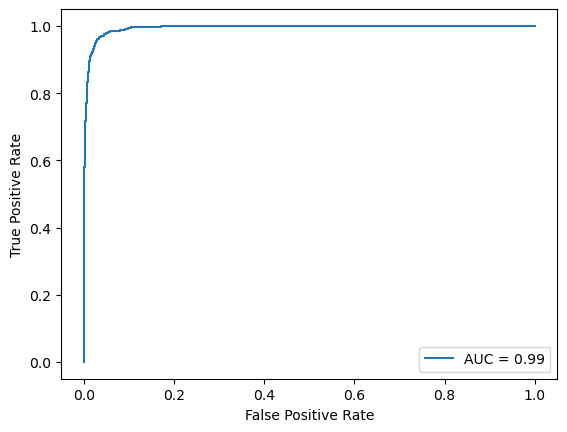

In [22]:
fpr, tpr, thresholds = roc_curve(
    y_true=fraud_model_evaluation['actual_label'].values,
    y_score=fraud_model_evaluation['predicted_probability'].values
)

roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

## 7 Explain the model

We now invoke the endpoint with online explainability enabled such that we can examine the feature importances. In the interest of time, we perform the analysis only for a few rows of the test dataset. 

In [23]:
# create a Clickhouse table for storing the results
client.command(
    '''
    drop table if exists fraud_model_explanation sync
    '''
)

client.command(
    '''
    create or replace table fraud_model_explanation (
        trans_date_trans_time DateTime,
        cc_num Int64,
        actual_label Float64,
        predicted_label Float64,
        predicted_probability Float64,
        merchant Float64,
        category Float64,
        customer_age Float64,
        customer_city Float64,
        transaction_amount Float64,
        transaction_hour Float64,
        transaction_weekday Float64,
        merchant_distance Float64,
        average_transaction_amount_1_day Float64,
        transaction_count_1_day Float64,
    )
    engine
        MergeTree
    order by
        trans_date_trans_time
    '''
)

# extract a few rows of test data from Clickhouse
test_data = client.query_df(
    '''
    select
        a.trans_date_trans_time as trans_date_trans_time,
        a.cc_num as cc_num,
        a.is_fraud as is_fraud,
        b.merchant as merchant,
        b.category as category,
        b.customer_age as customer_age,
        b.customer_city as customer_city,
        b.transaction_amount as transaction_amount,
        b.transaction_hour as transaction_hour,
        b.transaction_weekday as transaction_weekday,
        b.merchant_distance as merchant_distance,
        b.average_transaction_amount_1_day as average_transaction_amount_1_day,
        b.transaction_count_1_day as transaction_count_1_day
    from
        fraud_data as a
    left join
        fraud_feature_store as b
    on
        a.trans_date_trans_time == b.trans_date_trans_time
    and
        a.cc_num == b.cc_num
    where
        a.split == 'test'
    order by
        a.trans_date_trans_time asc
    limit 100
    '''
)

# invoke the endpoint with the test data
response = session.sagemaker_runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType='text/csv',
    Body=serializer.serialize(test_data.iloc[:, 3:]),
    EnableExplanations="`true`"
)

# deserialize the endpoint's response
response = deserializer.deserialize(response['Body'], 'text/csv')

# extract the predicted probabilities
probabilities = np.array(json.loads(response['predictions']['data'])['probabilities'])[:, 1]

# extract the Shapley values
explanations = pd.concat([
    pd.DataFrame(
        data={k['feature_header']: [k['attributions'][0]['attribution'][1]] for k in x}, 
    ) for x in response['explanations']['kernel_shap']
])

# save the results in the Clickhouse table
client.insert_df(
    'fraud_model_explanation',
    pd.DataFrame({
        'trans_date_trans_time': test_data['trans_date_trans_time'].values,
        'cc_num': test_data['cc_num'].values,
        'actual_label': test_data['is_fraud'].values,
        'predicted_label': np.where(probabilities > 0.5, 1., 0.),
        'predicted_probability': probabilities,
        'merchant': explanations['merchant'].values,
        'category': explanations['category'].values,
        'customer_age': explanations['customer_age'].values,
        'customer_city': explanations['customer_city'].values,
        'transaction_amount': explanations['transaction_amount'].values,
        'transaction_hour': explanations['transaction_hour'].values,
        'transaction_weekday': explanations['transaction_weekday'].values,
        'merchant_distance': explanations['merchant_distance'].values,
        'average_transaction_amount_1_day': explanations['average_transaction_amount_1_day'].values,
        'transaction_count_1_day': explanations['transaction_count_1_day'].values,
    })
)

We can now analyse the results in Clickhouse, where we saved both the model outputs and the feature attributions.

In [24]:
fraud_model_explanation = client.query_df('select * from fraud_model_explanation')

fraud_model_explanation.head()

,trans_date_trans_time,cc_num,actual_label,predicted_label,predicted_probability,merchant,category,customer_age,customer_city,transaction_amount,transaction_hour,transaction_weekday,merchant_distance,average_transaction_amount_1_day,transaction_count_1_day
0,2020-06-21 12:29:36,4110266553600176127,0.0,0.0,0.043027,0.009822,-0.024607,-0.000117,0.051592,0.001541,-0.142023,0.075535,-0.001902,0.003278,0.022960
1,2020-06-21 12:30:28,571465035400,0.0,0.0,0.002266,0.003185,0.008119,0.002833,-0.008840,-0.012704,-0.043705,0.003778,0.000000,0.000793,0.001858
2,2020-06-21 12:38:04,30234966027947,0.0,0.0,0.020926,0.008284,-0.060989,0.002558,-0.072823,0.274641,-0.183742,0.001149,0.000000,-0.003585,0.008483
3,2020-06-21 12:54:28,38947654498698,0.0,0.0,0.001707,0.011752,-0.095191,0.001101,-0.042993,0.165652,-0.107129,0.001043,0.000000,-0.001800,0.022323
4,2020-06-21 12:55:21,4503101193493052864,0.0,0.0,0.000274,0.006262,-0.031836,0.000842,-0.018299,0.025498,-0.040728,0.005063,-0.000118,0.000656,0.005986


The average absolute Shapley values indicate that the most important features are the transaction amount, the transaction category and the time and location of the transaction.

<Axes: >

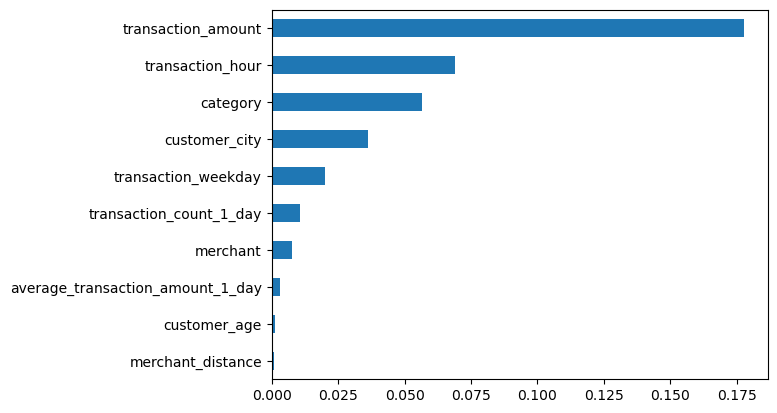

In [25]:
fraud_model_explanation.iloc[:, 5:].abs().mean().sort_values().plot(kind='barh')

## 8. Perform real-time inference

In the code below, we demonstrate a more realistic scenario where transaction events are processed in real-time. We stream the credit card transactions from Clickhouse as pairs of timestamp and account number, extract the transaction's features from the Clickhouse feature store, invoke the model endpoint with these features and save the results back to Clickhouse. In the interest of time, we run the code below only for a few transaction events.

In [26]:
# create a Clickhouse table for storing the results
client.command(
    '''
    drop table if exists fraud_real_time_predictions sync
    '''
)

client.command(
    '''
    create or replace table fraud_real_time_predictions (
        trans_date_trans_time DateTime,
        cc_num Int64,
        predicted_label Float64,
        predicted_probability Float64,
        merchant Float64,
        category Float64,
        customer_age Float64,
        customer_city Float64,
        transaction_amount Float64,
        transaction_hour Float64,
        transaction_weekday Float64,
        merchant_distance Float64,
        average_transaction_amount_1_day Float64,
        transaction_count_1_day Float64,
    )
    engine
        MergeTree
    order by
        trans_date_trans_time
    '''
)

# stream the transactions from Clickhouse
with client.query_rows_stream(
    '''
    select
        trans_date_trans_time,
        cc_num
    from
        fraud_data
    where
        split == 'test'
    order by
        trans_date_trans_time asc
    limit 10
    '''
    ) as stream:

    for row in stream:

        # lookup the transaction's features in the Clickhouse feature store
        features = client.query_df(
            f'''
            select
                merchant,
                category,
                customer_age,
                customer_city,
                transaction_amount,
                transaction_hour,
                transaction_weekday,
                merchant_distance,
                average_transaction_amount_1_day,
                transaction_count_1_day
            from
                fraud_feature_store
            where
                trans_date_trans_time == toDateTime('{str(row[0])}')
            and
                cc_num == {row[1]}
            '''
        )

        # invoke the endpoint with the features
        response = session.sagemaker_runtime_client.invoke_endpoint(
            EndpointName=predictor.endpoint_name,
            ContentType='text/csv',
            Body=serializer.serialize(features),
            EnableExplanations="`true`"
        )

        # deserialize the endpoint's response
        response = deserializer.deserialize(response['Body'], 'text/csv')

        # extract the predicted probabilities
        probabilities = json.loads(response['predictions']['data'])['probabilities'][0][1]

        # extract the Shap values
        explanations = {k['feature_header']: k['attributions'][0]['attribution'][1] for k in response['explanations']['kernel_shap'][0]}

        # save the results in the Clickhouse table
        client.insert_df(
            'fraud_real_time_predictions',
            pd.DataFrame({
                'trans_date_trans_time': row[0],
                'cc_num': row[1],
                'predicted_label': np.where(probabilities > 0.5, 1., 0.),
                'predicted_probability': probabilities,
                'merchant': explanations['merchant'],
                'category': explanations['category'],
                'customer_age': explanations['customer_age'],
                'customer_city': explanations['customer_city'],
                'transaction_amount': explanations['transaction_amount'],
                'transaction_hour': explanations['transaction_hour'],
                'transaction_weekday': explanations['transaction_weekday'],
                'merchant_distance': explanations['merchant_distance'],
                'average_transaction_amount_1_day': explanations['average_transaction_amount_1_day'],
                'transaction_count_1_day': explanations['transaction_count_1_day'],
            }, index=[0])
        )

We can then query Clickhouse to examine the results.

In [27]:
fraud_real_time_predictions = client.query_df('select * from fraud_real_time_predictions')

fraud_real_time_predictions.head()

,trans_date_trans_time,cc_num,predicted_label,predicted_probability,merchant,category,customer_age,customer_city,transaction_amount,transaction_hour,transaction_weekday,merchant_distance,average_transaction_amount_1_day,transaction_count_1_day
0,2020-06-21 13:48:14,3568255211412877,0.0,0.000486,0.006895,-0.001968,-0.000185,-0.017561,0.013688,-0.049589,0.004309,-0.001417,-0.003573,0.002939
1,2020-06-21 13:51:45,6011367958204270,0.0,0.001572,0.001609,-0.014919,-0.000182,-0.016747,0.024536,-0.045085,0.006577,0.000000,0.000931,-0.002097
2,2020-06-21 12:29:36,4110266553600176127,0.0,0.043027,0.009822,-0.024607,-0.000117,0.051592,0.001541,-0.142023,0.075535,-0.001902,0.003278,0.022960
3,2020-06-21 12:30:28,571465035400,0.0,0.002266,0.003185,0.008119,0.002833,-0.008840,-0.012704,-0.043705,0.003778,0.000000,0.000793,0.001858
4,2020-06-21 12:38:04,30234966027947,0.0,0.020926,0.008284,-0.060989,0.002558,-0.072823,0.274641,-0.183742,0.001149,0.000000,-0.003585,0.008483


After the analysis has been completed, we can delete the model and the endpoint.

In [28]:
predictor.delete_model()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2023-12-23-13-34-28-504


In [29]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-jumpstart-2023-12-23-13-34-28-504
INFO:sagemaker:Deleting endpoint with name: sagemaker-jumpstart-2023-12-23-13-34-28-504
